In [ ]:
!pip install -q -U watermark --quiet

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 32.1 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.20.1-py3-none-any.whl (4.4 MB)
     |████████████████████████████████| 596 kB 5.9 MB/s 
     |████████████████████████████████| 101 kB 10.6 MB/s 
     |████████████████████████████████| 6.6 MB 6.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install hydra-core

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 34.3 MB/s 
     |████████████████████████████████| 79 kB 7.7 MB/s 
     |████████████████████████████████| 117 kB 67.5 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=d6e562caecd468d78acb3dfe57231aa720d03d3c4891430d5a04d444505084f3
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime


In [ ]:
!pip install omegaconf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install bitarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 236 kB 14.0 MB/s 


In [ ]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 8.1 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.0+cu113
transformers: 4.20.1



In [ ]:
#from mumin import MuminDataset

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#dataset_path = "MyDrive/summer_proj/mumin-small.zip"
#dataset = MuminDataset(dataset_path)

In [ ]:
#dataset.compile()

2022-07-14 13:35:31,574 [INFO] Downloading dataset


In [ ]:
!pwd
!ls

/content
drive  mumin-small.zip	sample_data


Set Up

In [ ]:

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Data Exploration

In [28]:
dataset_path = 'drive/MyDrive/summer_proj/dataset/'
train_text = open(dataset_path+'train_text.txt').read().split('\n')
train_label = open(dataset_path+'train_label.txt').read().split('\n')

In [ ]:
train_label = pd.DataFrame(train_label)
train_label = train_label.rename(columns={0:'label'})
train_label['label'] = train_label['label'].replace(['misinformation'], 1)
train_label.head()


,label
0,1
1,1
2,1
3,1
4,1


### preprocess_dataset

In [ ]:
#xlmr = torch.hub.load('pytorch/fairseq:main', 'xlmr.base')
#xlmr.eval() 

In [ ]:
#https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/08.sentiment-analysis-with-bert.ipynb
#https://huggingface.co/xlm-roberta-base

In [13]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [71]:
PRE_TRAINED_MODEL_NAME = 'xlm-roberta-base'

In [14]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Simple Example

In [15]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [16]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['▁When', '▁was', '▁I', '▁last', '▁outside', '?', '▁I', '▁am', '▁stuck', '▁at', '▁home', '▁for', '▁2', '▁weeks', '.']
Token IDs: [14847, 509, 87, 4568, 50782, 32, 87, 444, 179933, 99, 5368, 100, 116, 40859, 5]


In [19]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [22]:
tokenizer.sep_token, tokenizer.sep_token_id

('</s>', 2)

In [23]:
tokenizer.cls_token, tokenizer.cls_token_id

('<s>', 0)

In [24]:
tokenizer.unk_token, tokenizer.unk_token_id

('<unk>', 3)

In [25]:
tokenizer.pad_token, tokenizer.pad_token_id

('<pad>', 1)

In [20]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([     0,  14847,    509,     87,   4568,  50782,     32,     87,    444,
        179933,     99,   5368,    100,    116,  40859,      5,      2,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1])

In [53]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [54]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['<s>',
 '▁When',
 '▁was',
 '▁I',
 '▁last',
 '▁outside',
 '?',
 '▁I',
 '▁am',
 '▁stuck',
 '▁at',
 '▁home',
 '▁for',
 '▁2',
 '▁weeks',
 '.',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

Choosing Sequence Length

In [29]:
token_lens = []

for txt in train_text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


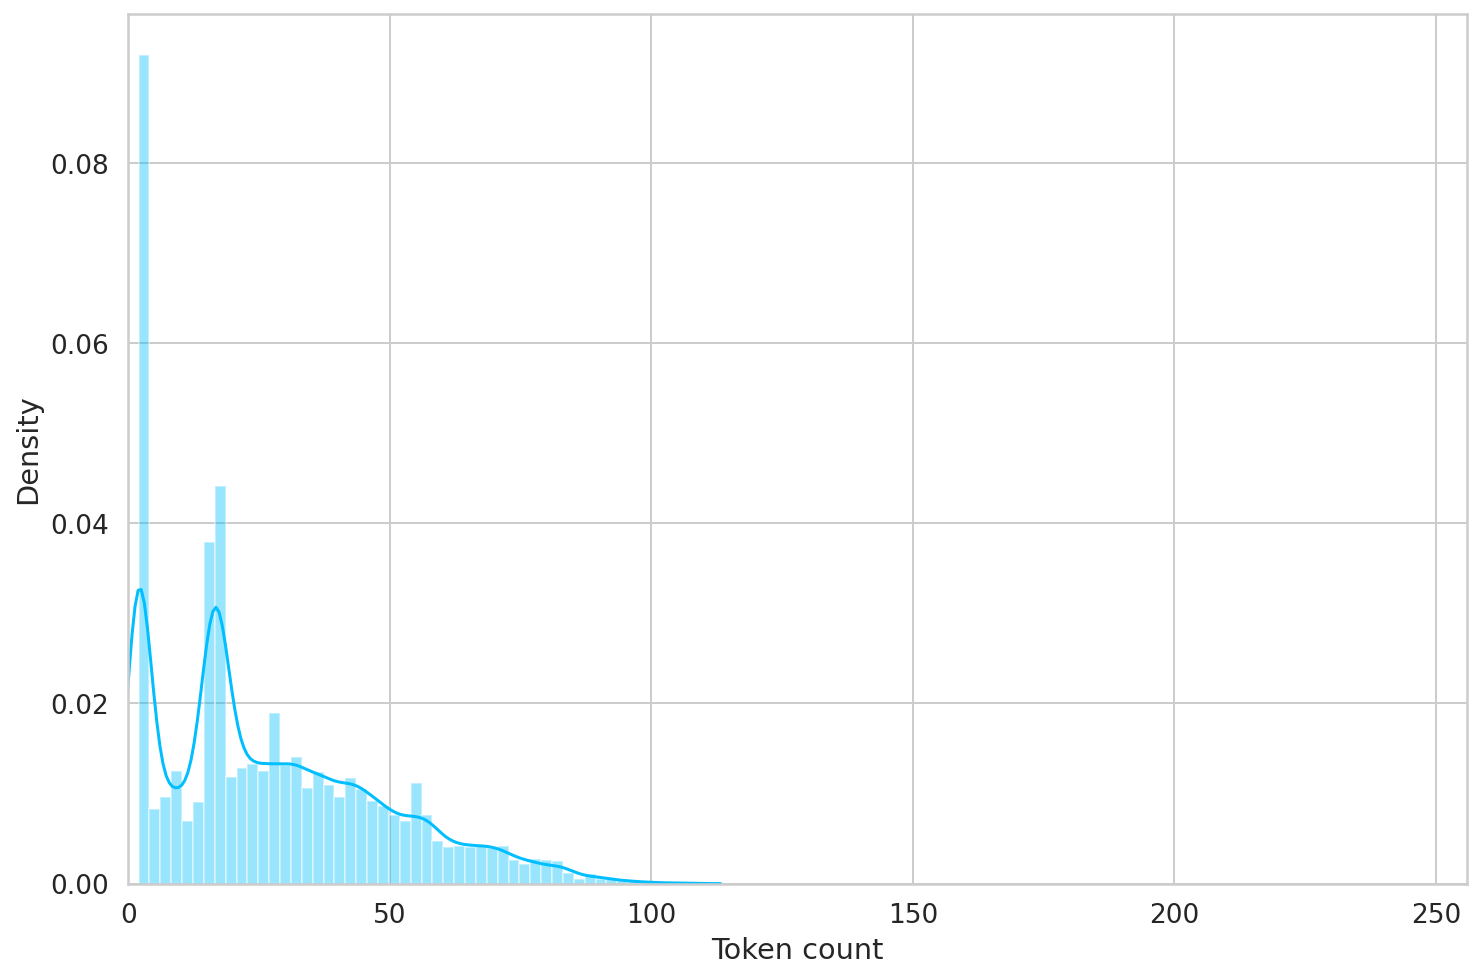

In [30]:

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [37]:
MAX_LEN = 125

In [57]:
df_train = pd.read_csv('drive/MyDrive/summer_proj/dataset/train_df.csv' )
df_test = pd.read_csv('drive/MyDrive/summer_proj/dataset/test_df.csv' )
df_val = pd.read_csv('drive/MyDrive/summer_proj/dataset/val_df.csv' )

In [63]:
df_train['label'] = df_train['label'].replace(['misinformation'], 1)
df_train['label'] = df_train['label'].replace(['factual'], 0)
df_train.head()

,Unnamed: 0,text,label
0,0,Antes de llegar a los pulmones dura 4 días en ...,1
1,1,Aeroporto de Dubai em chamas. 🤕😧 https://t.co/...,1
2,2,Fogo 🔥 no aeroporto de Dubai 😱😱 https://t.co/2...,1
3,3,Fogo no aeroporto de Dubai. https://t.co/yhQDe...,1
4,4,Incendio en el aeropuerto de Dubai https://t.c...,1


In [64]:
df_test['label'] = df_test['label'].replace(['misinformation'], 1)
df_test['label'] = df_test['label'].replace(['factual'], 0)
df_test.head()

,Unnamed: 0,text,label
0,79,Informação que aponta que @gilmarmendes mandou...,1
1,82,“Os fascistas do futuro se chamarão de anti-fa...,1
2,149,Usa : des policiers blancs arrêtent un homme n...,1
3,175,President of Guinea Bissau beating the ministe...,1
4,182,"Boletim de fake news - 23/09, 21h \nNovas\n- F...",1


In [65]:
df_val['label'] = df_val['label'].replace(['misinformation'], 1)
df_val['label'] = df_val['label'].replace(['factual'], 0)
df_val.head()

,Unnamed: 0,text,label
0,79,Informação que aponta que @gilmarmendes mandou...,1
1,82,“Os fascistas do futuro se chamarão de anti-fa...,1
2,149,Usa : des policiers blancs arrêtent un homme n...,1
3,175,President of Guinea Bissau beating the ministe...,1
4,182,"Boletim de fake news - 23/09, 21h \nNovas\n- F...",1


In [66]:

class MuminDataset(Dataset):

  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }


In [67]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MuminDataset(
    texts =df.text.to_numpy(),
    labels =df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [117]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [118]:
data = next(iter(train_data_loader))
data.keys()
#dict_keys(['twitter_text', 'input_ids', 'attention_mask', 'labels'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['twitter_text', 'input_ids', 'attention_mask', 'labels'])

In [147]:
val_data = next(iter(val_data_loader))
val_data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['twitter_text', 'input_ids', 'attention_mask', 'labels'])

In [148]:
val_input_ids = val_data['input_ids'].to(device)
val_attention_mask = val_data['attention_mask'].to(device)
val_labels = val_data['labels'].to(device)

In [119]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 125])
torch.Size([16, 125])
torch.Size([16])


Disinformation Classification with BERT and Hugging Face

In [120]:
import torch
import torch.nn as nn
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [121]:
num_classes = 2
input_dim = 768

In [ ]:
from torchtext.models import RobertaClassificationHead, XLMR_BASE_ENCODER
classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
model = XLMR_BASE_ENCODER.get_model(head=classifier_head)
model.to(DEVICE)

In [134]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
labels = data['labels'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(labels) # batch size x seq length

torch.Size([16, 125])
torch.Size([16, 125])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


In [149]:
import torchtext.functional as F
from torch.optim import AdamW

learning_rate = 1e-5
optim = AdamW(model.parameters(), lr=learning_rate)
criteria = nn.CrossEntropyLoss()


def train_step(input, target):
    output = model(input)
    loss = criteria(output, target)
    optim.zero_grad()
    loss.backward()
    optim.step()


def eval_step(input, target):
    output = model(input)
    loss = criteria(output, target).item()
    return float(loss), (output.argmax(1) == target).type(torch.float).sum().item()


def evaluate():
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    counter = 0
    with torch.no_grad():
        for batch in val_data_loader:
            input = val_input_ids.to(DEVICE)
            target = val_labels.to(DEVICE)
            loss, predictions = eval_step(input, target)
            total_loss += loss
            correct_predictions += predictions
            total_predictions += len(target)
            counter += 1

    return total_loss / counter, correct_predictions / total_predictions

In [150]:
padding_idx = 1
bos_idx = 0
eos_idx = 2

In [153]:
num_epochs = 10

for e in range(num_epochs):
  print(f'Epoch {e + 1}/{num_epochs}')
  print('-' * 10)
  
  for batch in train_data_loader:
    input = input_ids.to(DEVICE)
    target = labels.to(DEVICE)
    train_step(input, target)

  loss, accuracy = evaluate()
  print("Epoch = [{}], loss = [{}], accuracy = [{}]".format(e, loss, accuracy))

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Epoch = [0], loss = [0.0], accuracy = [1.0]
Epoch 2/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

KeyboardInterrupt: ignored